<a href="https://colab.research.google.com/github/Dipon12/Neural-Style-Transfer-in-Keras/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from PIL import Image

from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
print(tf.__version__)

2.2.0


In [3]:
model = VGG19(include_top=False,weights='imagenet')

80142336/80134624 [==============================] - 2s 0us/step


In [4]:
model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt


In [0]:
targetHeight=150
targetWidth=280

targetSize=(targetHeight,targetWidth)

def load_and_process(image_path):
  img = load_img(image_path,target_size=targetSize)
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img,axis=0)

  return img

In [0]:
def deprocess(x):       #opposite of preprocess_input...no helper function for deprocess
  x[:,:,0]+=103.939
  x[:,:,1]+=116.779
  x[:,:,2]+=123.68 #mean value of R G B for each pixel in imagenet dataset

  x = x[:,:,::-1] #reverses the array..The additional syntax of a[x::y] means get every yth element starting at position x..... BGR->RGB...3 no. e channel thake
  x= np.clip(x,0,255).astype('uint8')

  return x


In [0]:
def display(image,save_image=True):

  if len(image.shape)==4:
    image = np.squeeze(image,axis=0)

  image = deprocess(image)

  if save_image:
    image = Image.fromarray(image)
    image.save("Saved_Image.jpg")

  plt.imshow(image)
  return

In [9]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
cd '/content'

/content


In [11]:
ls

drive/  sample_data/


In [12]:
cd 'drive/My Drive/All Project Works/My Fancy Project/Neural Style Transfer'

/content/drive/My Drive/All Project Works/My Fancy Project/Neural Style Transfer


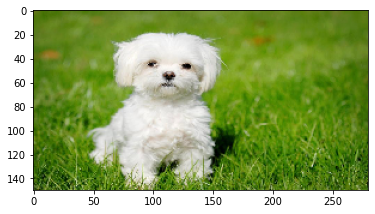

In [15]:
display(load_and_process('Content.jpg')) #preprocess kore than deprocess

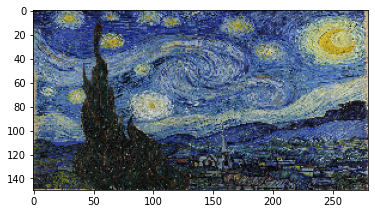

In [16]:
display(load_and_process('Style_5.jpeg')) #preprocess kore than deprocess

In [0]:
Content_layer='block5_pool'

Style_layer = [
               ('block1_conv2'),
               ('block2_conv1'),
               ('block2_conv2'),
               ('block3_conv1')
]

In [0]:
#For Content_image we need activations for content image...same with Style image

content_model=Model(inputs = model.input, outputs = model.get_layer(Content_layer).output) 

#This is like a separate model where input is models input and the models output is that layers output
#it is like the model stopped there...we dont need the whole vgg19 model
# so we need 4 models for style image as there are 4 layers
#input e image dile activation ki pai oitai record korbe era


style_model = []
for layer in Style_layer:
  style_model.append( Model(inputs = model.input, outputs=model.get_layer(layer).output))


In [0]:
def content_cost(content_img,generated_img):

  a_C=content_model(content_img)
  a_G=content_model(generated_img)

  c_loss = tf.reduce_mean(tf.square(a_C - a_G))

  return c_loss

In [0]:
def gram_matrix(A):

  n_C=int(A.shape[-1])

  A = tf.reshape(A,[-1,n_C])

  n = tf.shape(A)[0]

  gmatrix=tf.matmul(A,A,transpose_a=True)

  return gmatrix/tf.cast(n,tf.float32)


In [0]:
style_layer_weights = [1,0.5,0.3,0.1]

def style_cost(style_img,generated_img):
  s_cost=0
  co=0
  for s_model in style_model:

    a_S=s_model(style_img)
    a_G=s_model(generated_img)

    GS=gram_matrix(a_S)
    GG=gram_matrix(a_G)

    current_cost = tf.reduce_mean(tf.square(GS - GG))

    s_cost+= style_layer_weights[co]*current_cost
    co+=1

  return s_cost


In [0]:
generated_images=[]
J=0
ite = []
cost = []
s_cost = []
c_cost = []

def training(content_img_path,style_img_path,alpha=20.0,beta=400.0,iterations=2000):

  content_img = load_and_process(content_img_path)
  style_img=load_and_process(style_img_path)
  """
  

  generated = np.random.randint(low=0,high=255,size=(targetHeight,targetWidth,3)).astype('float64')
  generated = img_to_array(generated)
  generated = preprocess_input(generated)
  generated = np.expand_dims(generated,axis=0)
  """
  generated = tf.Variable(content_img, dtype=tf.float64)


  opt = tf.optimizers.Adam(learning_rate=6.0)

  min_cost = 1e20+0.1
  best_img = None

  for i in range(iterations):
    with tf.GradientTape() as tape:
      J_content = content_cost(content_img,generated)
      J_style = style_cost(style_img,generated)

      J = alpha * J_content + beta * J_style
    
      grads = tape.gradient(J,generated)
      opt.apply_gradients([(grads,generated)])

    ite.append(i)
    cost.append(J)
    s_cost.append(J_style)
    c_cost.append(J_content)




    if J<min_cost:
      min_cost=J
      best_img = generated.numpy()

    
    if i%10==0:
      generated_images.append(generated.numpy())

    print("Iteration: {},  Cost: {}, Style Cost: {}, Content Cost: {}".format(i+1,J,J_style,J_content))
   

  return best_img


In [0]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [25]:
alpha=10
beta=30
iterations=20
content_img_path='Content.jpg'
style_img_path='Style_5.jpeg'

generated_image = training(content_img_path,style_img_path)


Iteration: 1,  Cost: 979001540608.0, Style Cost: 2447503872.0, Content Cost: 0.0
Iteration: 2,  Cost: 754487328768.0, Style Cost: 1886218368.0, Content Cost: 13.283554077148438
Iteration: 3,  Cost: 583158398976.0, Style Cost: 1457896064.0, Content Cost: 42.979618072509766
Iteration: 4,  Cost: 447260098560.0, Style Cost: 1118150272.0, Content Cost: 75.24708557128906
Iteration: 5,  Cost: 342548840448.0, Style Cost: 856372096.0, Content Cost: 103.2406997680664
Iteration: 6,  Cost: 271349153792.0, Style Cost: 678372864.0, Content Cost: 125.77440643310547
Iteration: 7,  Cost: 232309997568.0, Style Cost: 580774976.0, Content Cost: 145.22015380859375
Iteration: 8,  Cost: 211337805824.0, Style Cost: 528344512.0, Content Cost: 162.47933959960938
Iteration: 9,  Cost: 192873070592.0, Style Cost: 482182656.0, Content Cost: 176.4501953125
Iteration: 10,  Cost: 171496472576.0, Style Cost: 428741184.0, Content Cost: 188.61843872070312
Iteration: 11,  Cost: 149418344448.0, Style Cost: 373545856.0, Con

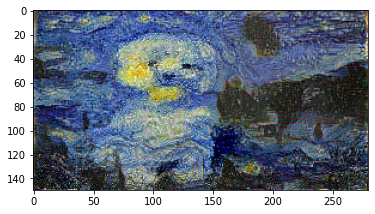

In [26]:
display(generated_image)


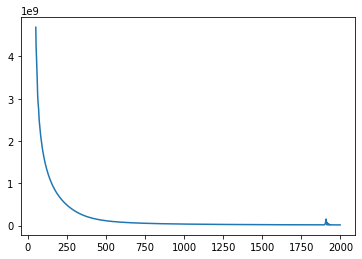

<function matplotlib.pyplot.plot>

In [27]:
plt.plot(ite[50:],cost[50:])
plt.show()

plt.plot

<function matplotlib.pyplot.plot>

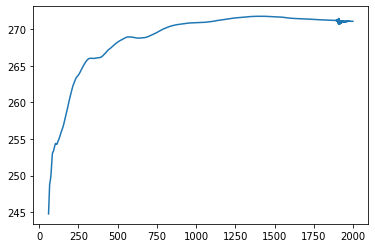

In [28]:
#plt.plot(ite[60:],s_cost[60:])
plt.plot(ite[60:],c_cost[60:])

plt.plot